In [1]:
%tensorflow_version 1.x
import pickle as pkl
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Embedding, RepeatVector, TimeDistributed, Bidirectional
from tensorflow.python.keras.callbacks import ModelCheckpoint
import tensorflow.python.keras.backend as K
import gc

TensorFlow 1.x selected.


In [2]:
# Imports for colab
from google.colab import drive
drive.mount('/content/gdrive')

dirname = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


# Preparations for training

## Load clean dataset

In [3]:
def load_clean_sentences(filename):
    return pkl.load(open(filename, 'rb'))

## Fit a tokenizer

In [4]:
def create_tokenizer(lines, num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, filters=filters, lower=lower, oov_token=oov_token)
    tokenizer.fit_on_texts(lines)
    return tokenizer

## Compute max length of sentence

In [5]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

## Encode and pad sequences

In [6]:
def encode_sequences(tokenizer, length, lines):
    # Encode sequences
    X = tokenizer.texts_to_sequences(lines)

    # Pad sequences with zeros
    X = pad_sequences(X, maxlen=length, padding='post')

    return X

## One-hot encoding

One-hot encoding is required for target translation, because NN have to predict probability of next word

In [7]:
def encode_output(sequences, vocab_size):
    y = np.zeros([sequences.shape[0], sequences.shape[1], vocab_size], dtype=np.int8)
    for i in range(sequences.shape[0]):
        y[i] = to_categorical(sequences[i], num_classes=vocab_size, dtype=np.int8)
    return y

## Define model

In [8]:
def define_model(source_vocab, target_vocab, source_timesteps, target_timesteps, n_units):
    model = Sequential()
    # Embedding layer: source_vocab - input vocabulary, n_units - number on neurons in layer, mask_zero - output 0 if input is 0
    model.add(Embedding(source_vocab, n_units, input_length=source_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(n_units)))
    # Repeats input target_timesteps times
    model.add(RepeatVector(target_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(target_vocab, activation='softmax')))
    return model

# Training
X - data, y - target

In [9]:
# Load datasets

dataset = load_clean_sentences(dirname + 'english-russian-100k-both.pkl')
len_data = len(dataset)
train = load_clean_sentences(dirname + 'english-russian-100k-train.pkl')
test = load_clean_sentences(dirname + 'english-russian-100k-test.pkl')

In [10]:
# Prepare english tokenizer
base_tok_name = str(len_data//1000) + 'k'

eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1 #+1 because of <EOS> token
eng_length = max_length(dataset[:, 0])
print('English vocabulary size: %d' % eng_vocab_size)
print('English max sentence length: %d' % eng_length)

pkl.dump(eng_tokenizer, open(dirname + 'en_tokenizer_%s' % base_tok_name, 'wb'))

English vocabulary size: 7313
English max sentence length: 7


In [11]:
# Prepare russian tokenizer
rus_tokenizer = create_tokenizer(dataset[:, 1])
rus_vocab_size = len(rus_tokenizer.word_index) + 1
rus_length = max_length(dataset[:, 1])
print('Russian vocabulary size: %d' % rus_vocab_size)
print('Russian max sentence length: %d' % rus_length)

pkl.dump(rus_tokenizer, open(dirname + 'ru_tokenizer_%s' % base_tok_name, 'wb'))

Russian vocabulary size: 20884
Russian max sentence length: 11


In [12]:
# Prepare training data
X_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [13]:
y_train = encode_sequences(rus_tokenizer, rus_length, train[:, 1])

In [14]:
y_train = encode_output(y_train, rus_vocab_size)

In [15]:
# Prepare validation data
X_val = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
y_val = encode_sequences(rus_tokenizer, rus_length, test[:, 1])
y_val = encode_output(y_val, rus_vocab_size)

In [16]:
# Define model
K.clear_session()
model = define_model(eng_vocab_size, rus_vocab_size, eng_length, rus_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 256)            1872128   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1050624   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 11, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 256)           787456    
_________________________________________________________________
time_distributed (TimeDistri (None, 11, 20884)         5367188   
Total params: 9,077,396
Trainable params: 9,077,396
Non-trainable params: 0
_________________________________________________________________
None


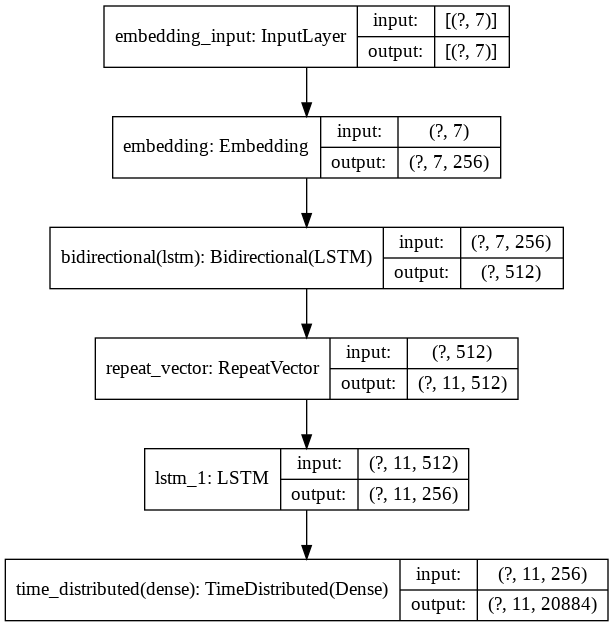

In [17]:
# Model overview
print(model.summary())
plot_model(model, to_file=dirname + 'model_basic_bidirectional.png', show_shapes=True)

In [18]:
#Fit model
epochs = 100
base_name = '%dk_%de' % ((len_data//1000, epochs))

filename = dirname + 'model_bidirectional_%s.h5' % base_name
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), callbacks=[checkpoint], verbose=2)

Train on 90000 samples, validate on 10000 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.03938, saving model to /content/gdrive/My Drive/Colab Notebooks/model_bidirectional_100k_100e.h5
90000/90000 - 123s - loss: 2.4449 - val_loss: 2.0394
Epoch 2/100

Epoch 00002: val_loss improved from 2.03938 to 1.62955, saving model to /content/gdrive/My Drive/Colab Notebooks/model_bidirectional_100k_100e.h5
90000/90000 - 110s - loss: 1.8021 - val_loss: 1.6296
Epoch 3/100

Epoch 00003: val_loss improved from 1.62955 to 1.35073, saving model to /content/gdrive/My Drive/Colab Notebooks/model_bidirectional_100k_100e.h5
90000/90000 - 110s - loss: 1.4213 - val_loss: 1.3507
Epoch 4/100

Epoch 00004: val_loss improved from 1.35073 to 1.16613, saving model to /content/gdrive/My Drive/Colab Notebooks/model_bidirectional_100k_100e.h5
90000/90000 - 111s - loss: 1.1407 - val_loss: 1.1661
Epoch 5/100

Epoch 00005: val_loss improved from 1.16613 to 1.03634, saving model to /content/gdrive/My Dr

## Overview

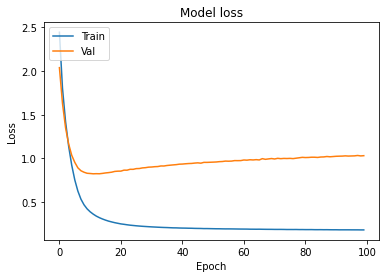

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(dirname + 'model_bidirectional_%s_loss.png' % base_name)
plt.show()